In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

sns.set_style('darkgrid')
df = pd.read_csv('market_data.csv', index_col='Date')

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
raw_data = pd.read_csv('gamma.csv')
df = raw_data.copy()

In [4]:
map_values = {'g' : 1.0, 'h' : 0.0}
df['class'] = df['class'].map(map_values)

In [5]:
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fMLong,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1.0
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1.0
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1.0
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1.0
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1.0


In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
X_train, y_train = np.asarray(train.iloc[:,:-1]), np.asarray(train.iloc[:,-1])
X_test, y_test = np.asarray(test.iloc[:,:-1]), np.asarray(test.iloc[:,-1])
X_labels = list(df.columns)[:-1]

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import sklearn

y = np.asarray(df['class'])
model_scores = pd.DataFrame(index=['Accuracy', 'F1', 'Precision', 'Recall'])
model_scores.loc['Accuracy', 'Base Case'] = max(accuracy_score(y, [0] * len(y)), 1 - accuracy_score(y, [0] * len(y)))
model_scores.loc['F1', 'Base Case'] = f1_score(y, [0] * len(y))
model_scores.loc['Precision', 'Base Case'] = precision_score(y, [0] * len(y))
model_scores.loc['Recall', 'Base Case'] = recall_score(y, [0] * len(y))
model_scores.loc['ROC-AUC', 'Base Case'] = roc_auc_score(y, [0] * len(y))
base_accuracy = model_scores.loc['Accuracy', 'Base Case']
base_roc_auc = model_scores.loc['ROC-AUC', 'Base Case']
model_scores

,Base Case
Accuracy,0.64837
F1,0.00000
Precision,0.00000
Recall,0.00000
ROC-AUC,0.50000


In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15216, 10), (15216,), (3804, 10), (3804,))

In [63]:
def get_cv_df(rng, model_type):    # change param
    cv_accuracy = []
    cv_precision = []
    cv_recall = []
    cv_f1 = []
    cv_roc_auc = []
    for i in rng:
        if model_type == 'decision tree':
            clf = DecisionTreeClassifier(max_depth=i, criterion='entropy', random_state=42)    # change classifier
        elif model_type == 'boosting':
            clf = GradientBoostingClassifier(max_depth=2, n_estimators=i, random_state=42)
        elif model_type == 'linear svm':
            clf = LinearSVC(loss='hinge', C=i, random_state=42)
        elif model_type == 'kernel svm':
            clf = SVC(kernel='poly', degree=i, random_state=42)
        else:
            clf = KNeighborsClassifier(n_neighbors=i)
            
        cv_accuracy.append(cross_val_score(clf, X_train, y_train, cv=10).mean())
        cv_precision.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='precision').mean())
        cv_recall.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='recall').mean())
        cv_f1.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='f1').mean())
        cv_roc_auc.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc').mean())
    cv_df = pd.DataFrame()
    cv_df['Parameter'] = rng
    cv_df['CV Accuracy'] = cv_accuracy
    cv_df['CV Precision'] = cv_precision
    cv_df['CV Recall'] = cv_recall
    cv_df['CV F1'] = cv_f1 #2 * (cv_df['CV Precision'] * cv_df['CV Recall']) / (cv_df['CV Precision'] + cv_df['CV Recall'])
    cv_df['CV ROC-AUC'] = cv_roc_auc
    cv_df.index = cv_df['Parameter']
    cv_df.drop('Parameter', axis=1, inplace=True)
    return cv_df

def get_final(clf):
    sns.set(font_scale=1.4)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm_df = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    if type(clf) == sklearn.svm.classes.SVC or type(clf) == sklearn.ensemble.gradient_boosting.GradientBoostingClassifier or type(clf) == sklearn.svm.classes.LinearSVC:
        fpr, tpr, thresholds = roc_curve(y_test, clf.decision_function(X_test))
    else:
        fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

    fig, axs = plt.subplots(1, 2, figsize=(20,8))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap=ListedColormap(['lightblue']), cbar=False, linewidths=1, ax=axs[0]);
    axs[0].set_title('Confusion Matrix', fontsize=14)
    axs[1].plot(fpr, tpr)
    axs[1].plot([0,1], [0,1], 'k--')
    axs[1].axis([0,1,0,1])
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_title('ROC Curve', fontsize=14);
    
    acc = cross_val_score(clf, X_train, y_train, cv=10).mean()
    prec = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision').mean()
    rec = cross_val_score(clf, X_train, y_train, cv=10, scoring='recall').mean()
    f1 = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1').mean()
    roc_auc = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc').mean()
    return acc, prec, rec, f1, roc_auc

def plot_results(df_plot, model_type, x_label):
    sns.set(font_scale=1)
    df_plot['Base Accuracy'] = base_accuracy
    df_plot['Base ROC-AUC'] = base_roc_auc
    
    y_acc = df_plot[['CV Accuracy', 'Base Accuracy']]
    y_f1 = df_plot[['CV F1']]
    y_prec = df_plot[['CV Precision']]
    y_rec = df_plot[['CV Recall']]
    y_auc = df_plot[['CV ROC-AUC', 'Base ROC-AUC']]
    y_comb = df_plot

    fig, axs = plt.subplots(2, 3, figsize=(20,12))
    fig.suptitle(model_type + ' Perfomrance Measures', fontsize=18)
    axs[0,0].plot(y_acc)
    axs[0,0].set_title('Accuracy', fontsize=14)
    axs[0,0].legend((y_acc.columns))
    axs[0,1].plot(y_f1)
    axs[0,1].set_title('F1', fontsize=14)
    axs[0,1].legend((y_f1.columns))
    axs[1,0].plot(y_prec)
    axs[1,0].set_title('Precision', fontsize=14)
    axs[1,0].set_xlabel(x_label)
    axs[1,0].legend(y_prec.columns)
    axs[1,1].plot(y_rec)
    axs[1,1].set_title('Recall', fontsize=14)
    axs[1,1].set_xlabel(x_label)
    axs[1,1].legend(y_rec.columns)
    axs[0,2].plot(y_auc)
    axs[0,2].set_title('ROC-AUC', fontsize=14)
    axs[0,2].legend(y_auc.columns)
    axs[1,2].plot(y_comb)
    axs[1,2].set_title('Combined Validation Metrics', fontsize=14)
    axs[1,2].set_xlabel(x_label)
    axs[1,2].legend(df_plot.columns)
    axs[1,2].set_ylim(0,1);
    
    fig, axs = plt.subplots(1, 2, figsize=(20,8))
    fig.suptitle(model_type + ' Perfomrance Comparisons', fontsize=16)
    axs[0].plot(df_plot[['CV Precision', 'CV Recall']])
    axs[0].set_xlabel(x_label)
    axs[0].legend(['CV Precision', 'CV Recall'])
    axs[0].set_ylim(0,1)
    axs[1].plot(df_plot[['CV F1', 'CV ROC-AUC', 'CV Accuracy']])
    axs[1].set_xlabel(x_label)
    axs[1].legend(['Validation F1', 'Validation ROC-AUC', 'Validation Accuracy'])
    plt.ylim(0,1);

### Decision Tree

In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

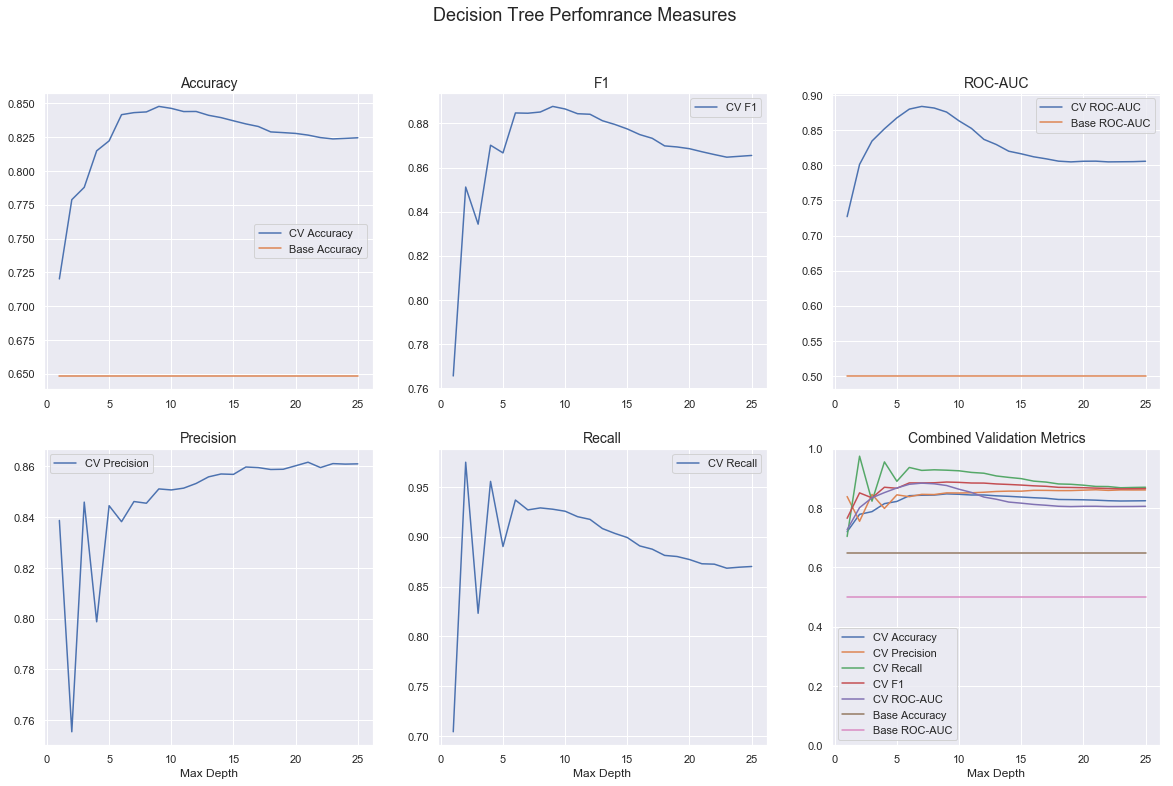

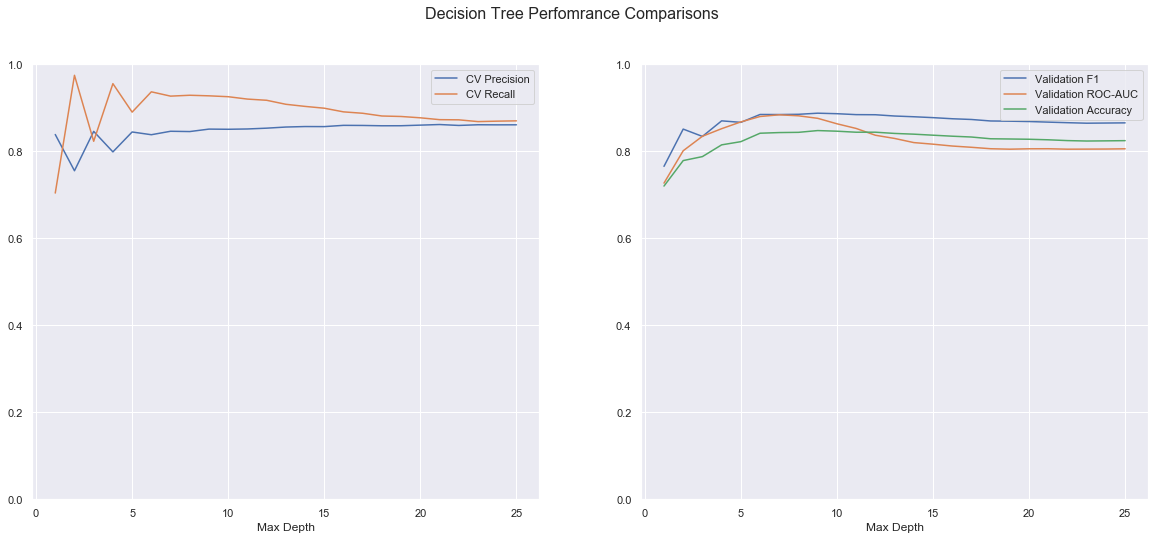

In [69]:
dt_df = get_cv_df(range(1,26), 'decision tree')
plot_results(dt_df, 'Decision Tree', 'Max Depth')

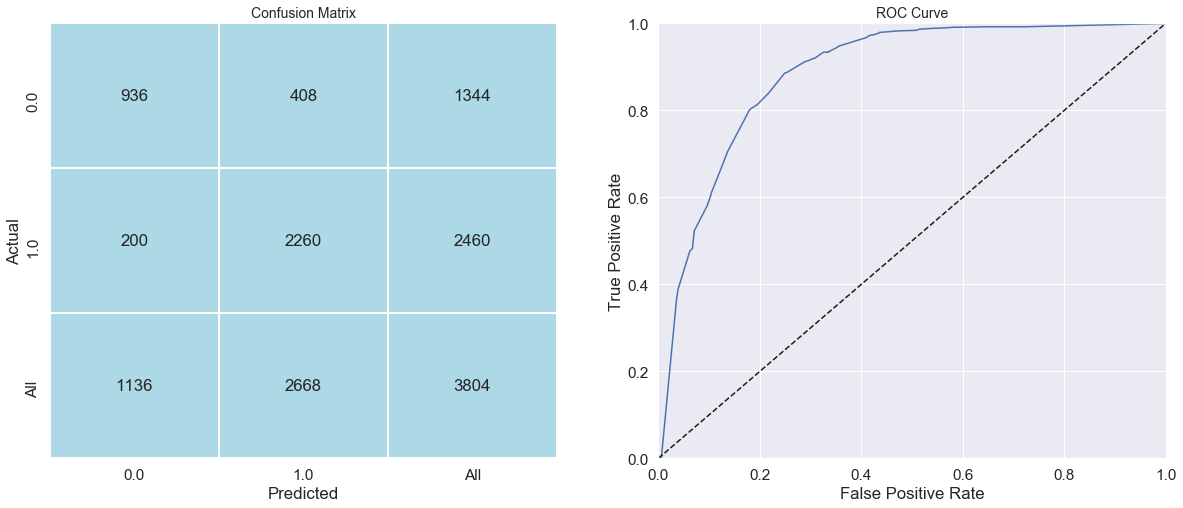

In [70]:
tree_clf = DecisionTreeClassifier(max_depth=dt_df['CV ROC-AUC'].argmax(), criterion='entropy', random_state=42)
scores = get_final(tree_clf)

In [71]:
model_scores['Decision Tree'] = [scores[i] for i in range(len(scores))]
model_scores

,Base Case,Decision Tree,Dense Neural Network,Boosting,Linear SVM,Kernel SVM,KNN
Accuracy,0.64837,0.843192,0.866982,0.862972,0.791340,0.800607,0.839709
F1,0.00000,0.846179,0.858589,0.857452,0.804669,0.777555,0.824584
Precision,0.00000,0.926968,0.950939,0.946109,0.895969,0.970320,0.956443
Recall,0.00000,0.884657,0.900522,0.899580,0.847822,0.863296,0.885612
ROC-AUC,0.50000,0.884000,0.913310,0.914000,0.834557,0.878045,0.900733


In [15]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn import tree

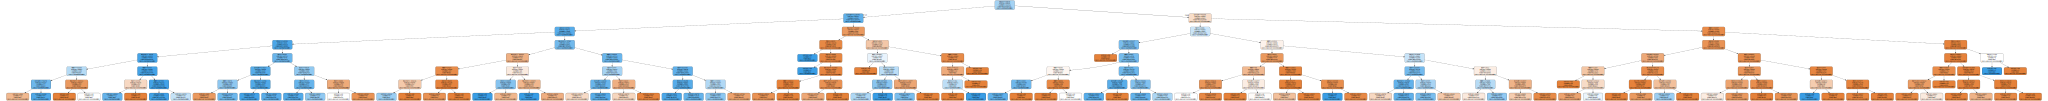

In [16]:
graph = Source(tree.export_graphviz(tree_clf, 
                                    out_file=None, 
                                    feature_names=X_labels, 
                                    class_names=['Background Radiation', 'Gamma Radiation'], 
                                    rounded=True, 
                                    filled=True))
display(SVG(graph.pipe(format='svg')))

### Neural Network

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
#https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
#https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
from keras import backend as K
import tensorflow as tf

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

Using TensorFlow backend.


In [19]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(6, activation='relu', input_shape=(10,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(2, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
np.random.seed(42)
model.compile(optimizer='rmsprop', 
             loss='binary_crossentropy', 
             metrics=['accuracy', precision, recall, f1, auroc])

In [21]:
history = model.fit(X_train, 
                   y_train, 
                   epochs=150, 
                   batch_size=512, 
                   validation_split=0.2)

Train on 12172 samples, validate on 3044 samples
Epoch 1/150
12172/12172 [==============================] - 1s 112us/step - loss: 0.6904 - acc: 0.6414 - precision: 0.6296 - recall: 0.9329 - f1: 0.7515 - auroc: 0.5221 - val_loss: 0.6878 - val_acc: 0.6669 - val_precision: 0.6657 - val_recall: 0.9804 - val_f1: 0.7927 - val_auroc: 0.5373
Epoch 2/150
12172/12172 [==============================] - 0s 7us/step - loss: 0.6860 - acc: 0.6654 - precision: 0.6661 - recall: 0.9709 - f1: 0.7899 - auroc: 0.5606 - val_loss: 0.6834 - val_acc: 0.6767 - val_precision: 0.6745 - val_recall: 0.9717 - val_f1: 0.7962 - val_auroc: 0.5943
Epoch 3/150
12172/12172 [==============================] - 0s 7us/step - loss: 0.6810 - acc: 0.6819 - precision: 0.6811 - recall: 0.9582 - f1: 0.7961 - auroc: 0.6201 - val_loss: 0.6773 - val_acc: 0.7050 - val_precision: 0.6998 - val_recall: 0.9572 - val_f1: 0.8083 - val_auroc: 0.6513
Epoch 4/150
12172/12172 [==============================] - 0s 8us/step - loss: 0.6734 - acc: 0

In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'val_precision', 'val_recall', 'val_f1', 'val_auroc', 'loss', 'acc', 'precision', 'recall', 'f1', 'auroc'])

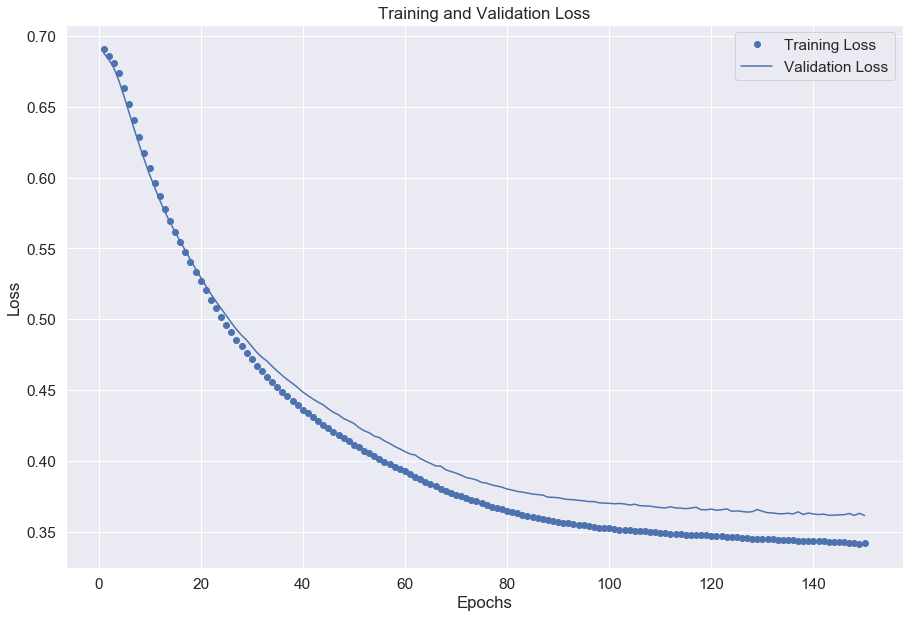

In [23]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,10))
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [24]:
def nn_plot():
    #df_plot = pd.merge(df_boost_train[trn_cv_cols], df_boost_valid[val_cv_cols], left_index=True, right_index=True)
    df_plot = pd.DataFrame(history_dict)
    df_plot['Epochs'] = epochs
    df_plot.index = df_plot['Epochs']
    df_plot['Base Accuracy'] = base_accuracy
    df_plot['Base ROC-AUC'] = base_roc_auc

    y_acc = df_plot[['acc', 'val_acc', 'Base Accuracy']] #[['Training Accuracy', 'Validation Accuracy', 'Base Accuracy']]
    y_f1 = df_plot[['f1', 'val_f1']] #[['Training F1', 'Validation F1']]
    y_prec = df_plot[['precision', 'val_precision']] #[['Training Precision', 'Validation Precision']]
    y_rec = df_plot[['recall', 'val_recall']] #[['Training Recall', 'Validation Recall']]
    y_auc = df_plot[['auroc', 'val_auroc']] #[['Training ROC-AUC', 'Validation ROC-AUC', 'Base ROC-AUC']]

    fig, axs = plt.subplots(2, 3, figsize=(20,12))
    fig.suptitle('Neural Network Performance Measures', fontsize=18)
    axs[0,0].plot(y_acc)
    axs[0,0].set_title('Accuracy', fontsize=14)
    axs[0,0].legend((['Training Accuracy', 'Validation Accuracy', 'Base Accuracy']))
    axs[0,1].plot(y_f1)
    axs[0,1].set_title('F1', fontsize=14)
    axs[0,1].legend((['Training F1', 'Validation F1']))
    axs[1,0].plot(y_prec)
    axs[1,0].set_title('Precision', fontsize=14)
    axs[1,0].set_xlabel('Epochs')
    axs[1,0].legend(['Training Precision', 'Validation Precision'])
    axs[1,1].plot(y_rec)
    axs[1,1].set_title('Recall', fontsize=14)
    axs[1,1].set_xlabel('Epochs')
    axs[1,1].legend(['Training Recall', 'Validation Recall'])
    axs[0,2].plot(y_auc)
    axs[0,2].set_title('ROC-AUC', fontsize=14)
    axs[0,2].legend(['Training ROC-AUC', 'Validation ROC-AUC', 'Base ROC-AUC'])
    axs[1,2].plot(df_plot[['val_acc', 'val_precision', 'val_recall', 'val_f1', 'val_auroc']])
    axs[1,2].set_title('Combined Validation Metrics', fontsize=14)
    axs[1,2].set_xlabel('Epochs')
    axs[1,2].legend(['Validation Accuracy', 'Validation Precisioin', 'Validation Recall', 'Validation F1', 'Validation ROC-AUC'])
    axs[1,2].set_ylim(0,1);

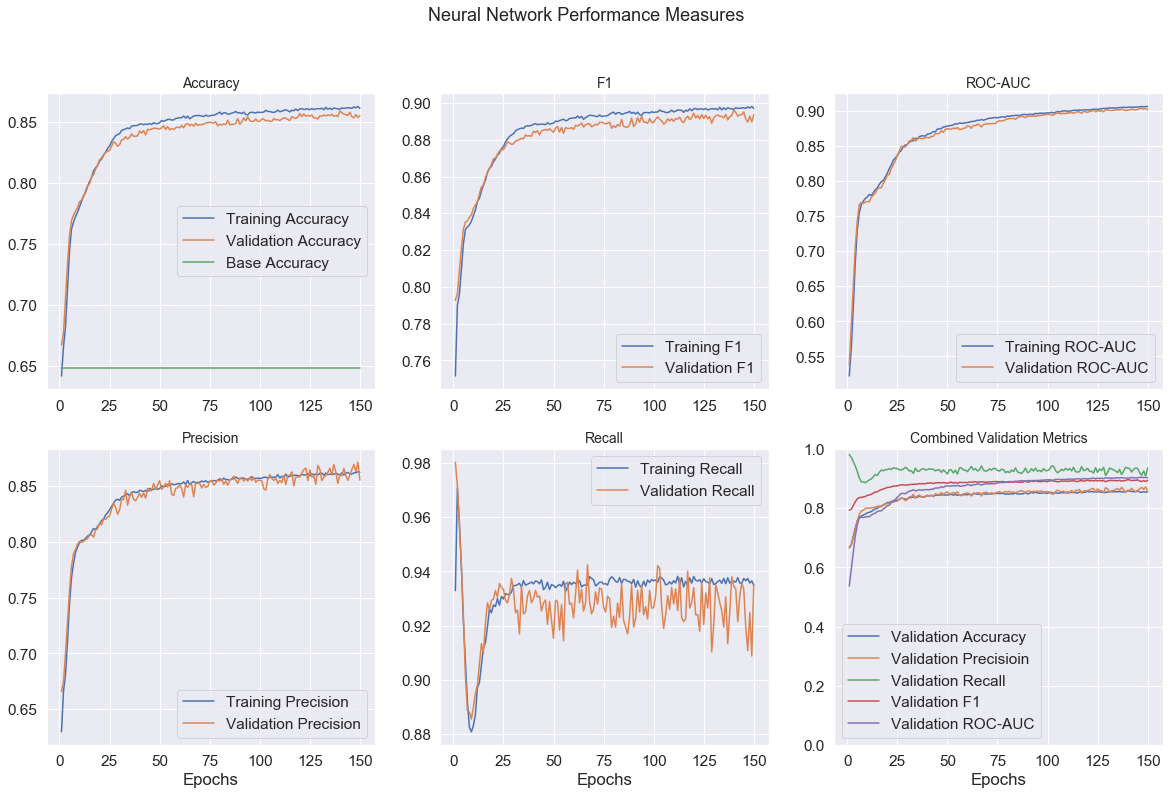

In [25]:
nn_plot()

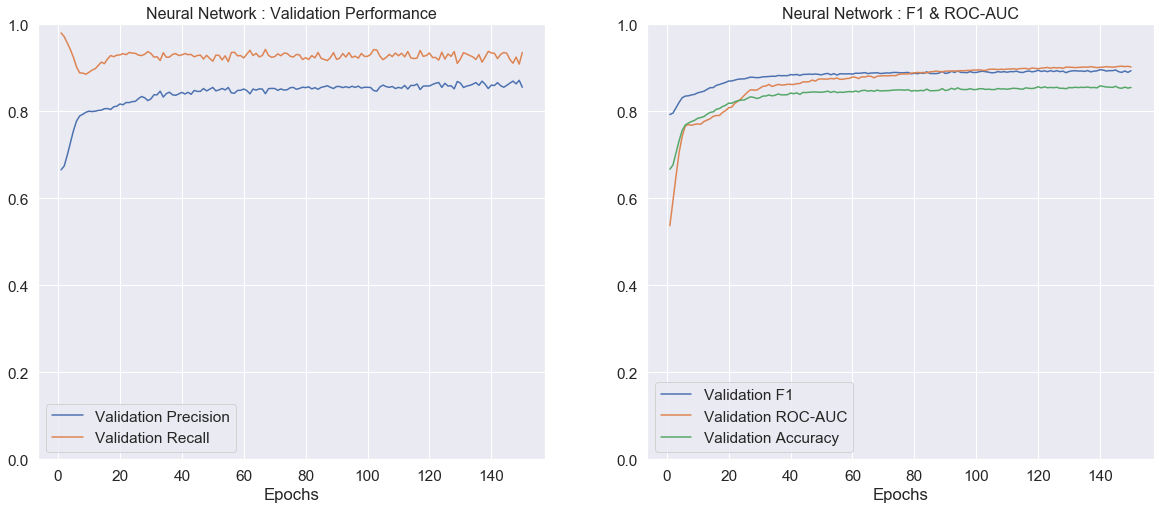

In [26]:
df_plot = pd.DataFrame(history_dict)
df_plot['Epochs'] = epochs
df_plot.index = df_plot['Epochs']
df_plot['Base Accuracy'] = base_accuracy
df_plot['Base ROC-AUC'] = base_roc_auc

fig, axs = plt.subplots(1, 2, figsize=(20,8))

axs[0].plot(df_plot[['val_precision', 'val_recall']])
axs[0].set_xlabel('Epochs')
axs[0].set_title('Neural Network : Validation Performance', fontsize=16)
axs[0].legend(['Validation Precision', 'Validation Recall'])
axs[0].set_ylim(0,1)
axs[1].plot(df_plot[['val_f1', 'val_auroc', 'val_acc']])
axs[1].set_title('Neural Network : F1 & ROC-AUC', fontsize=16)
axs[1].set_xlabel('Epochs')
axs[1].legend(['Validation F1', 'Validation ROC-AUC', 'Validation Accuracy'])
plt.ylim(0,1);

In [81]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(6, activation='relu', input_shape=(10,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(2, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

np.random.seed(42)
model.compile(optimizer='rmsprop', 
             loss='binary_crossentropy', 
             metrics=['accuracy', precision, recall, f1, auroc])

model.fit(X_train, y_train, epochs=df_plot['val_auroc'].argmax(), batch_size=512)
results = model.evaluate(X_test, y_test)

Epoch 1/147
15216/15216 [==============================] - 0s 29us/step - loss: 0.6754 - acc: 0.6616 - precision: 0.6811 - recall: 0.9010 - f1: 0.7750 - auroc: 0.5356
Epoch 2/147
15216/15216 [==============================] - 0s 7us/step - loss: 0.6487 - acc: 0.6941 - precision: 0.6918 - recall: 0.9530 - f1: 0.8016 - auroc: 0.6052
Epoch 3/147
15216/15216 [==============================] - 0s 7us/step - loss: 0.6159 - acc: 0.7229 - precision: 0.7136 - recall: 0.9573 - f1: 0.8175 - auroc: 0.6722
Epoch 4/147
15216/15216 [==============================] - 0s 7us/step - loss: 0.5752 - acc: 0.7491 - precision: 0.7360 - recall: 0.9565 - f1: 0.8316 - auroc: 0.7385
Epoch 5/147
15216/15216 [==============================] - 0s 7us/step - loss: 0.5317 - acc: 0.7695 - precision: 0.7567 - recall: 0.9504 - f1: 0.8424 - auroc: 0.7969
Epoch 6/147
15216/15216 [==============================] - 0s 7us/step - loss: 0.4908 - acc: 0.7871 - precision: 0.7755 - recall: 0.9455 - f1: 0.8520 - auroc: 0.8337
Epo

In [28]:
model_scores['Dense Neural Network'] = results[1:]
model_scores

,Base Case,Decision Tree,Dense Neural Network
Accuracy,0.64837,0.843192,0.866982
F1,0.00000,0.846179,0.858589
Precision,0.00000,0.926968,0.950939
Recall,0.00000,0.884657,0.900522
ROC-AUC,0.50000,0.884000,0.913310


In [83]:
y_pred = model.predict(X_test)
model_predictions = np.asarray([round(num[0],0) for num in y_pred])

cm_df = pd.crosstab(y_test, model_predictions, rownames=['Actual'], colnames=['Predicted'], margins=True)
roc = roc_curve(y_test, y_pred)

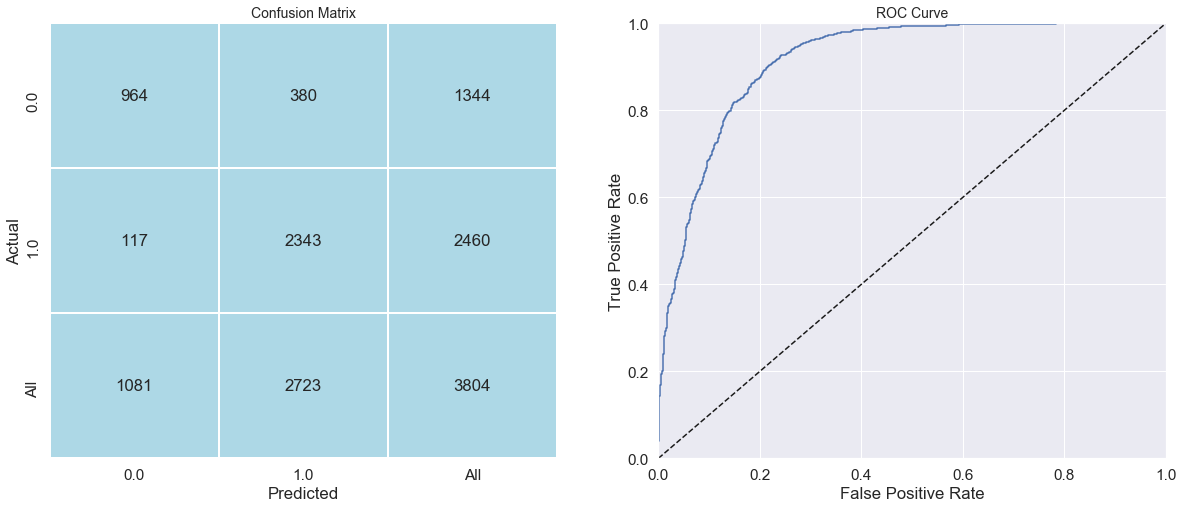

In [84]:
fpr, tpr, thresholds = roc[0], roc[1], roc[2]

from matplotlib.colors import ListedColormap

fig, axs = plt.subplots(1, 2, figsize=(20,8))
sns.set(font_scale=1.4)
sns.heatmap(cm_df, annot=True, fmt='g', cmap=ListedColormap(['lightblue']), cbar=False, linewidths=1, ax=axs[0]);
sns.set(font_scale=1)
axs[0].set_title('Confusion Matrix', fontsize=14)
axs[1].plot(fpr, tpr)
axs[1].plot([0,1], [0,1], 'k--')
axs[1].axis([0,1,0,1])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curve', fontsize=14);

### Boosting

In [72]:
from sklearn.ensemble import GradientBoostingClassifier

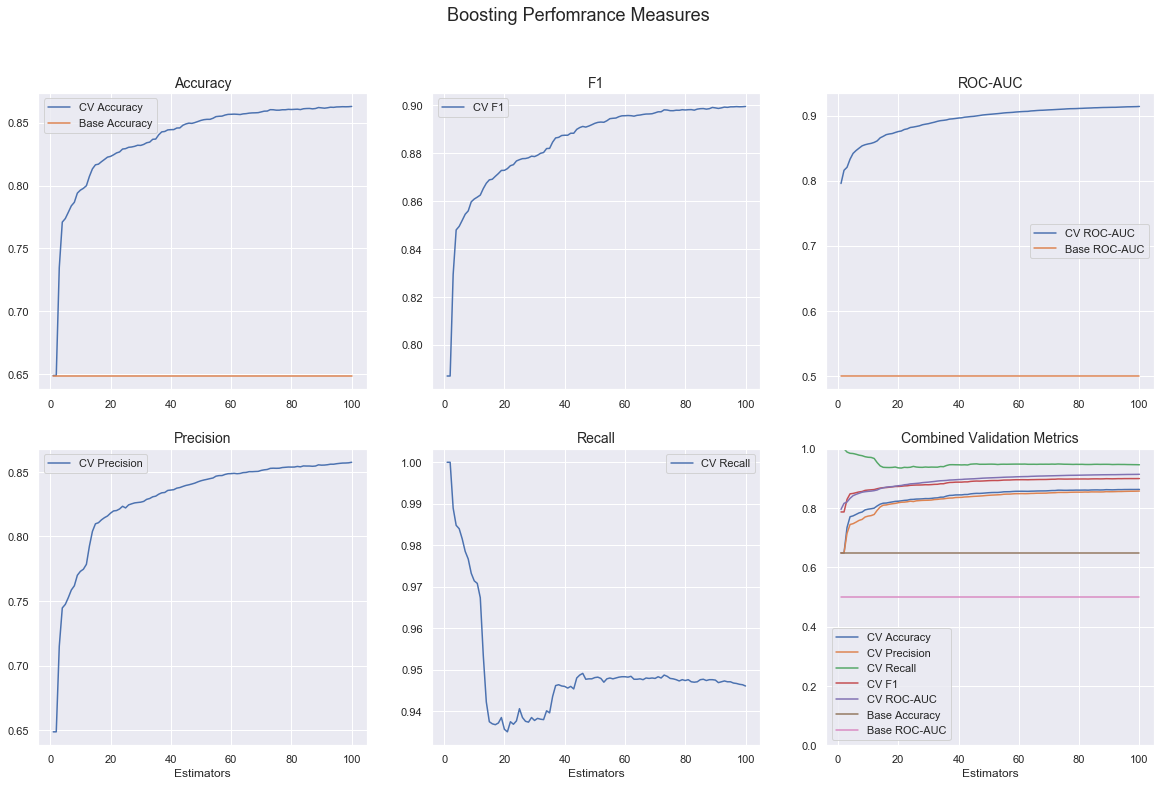

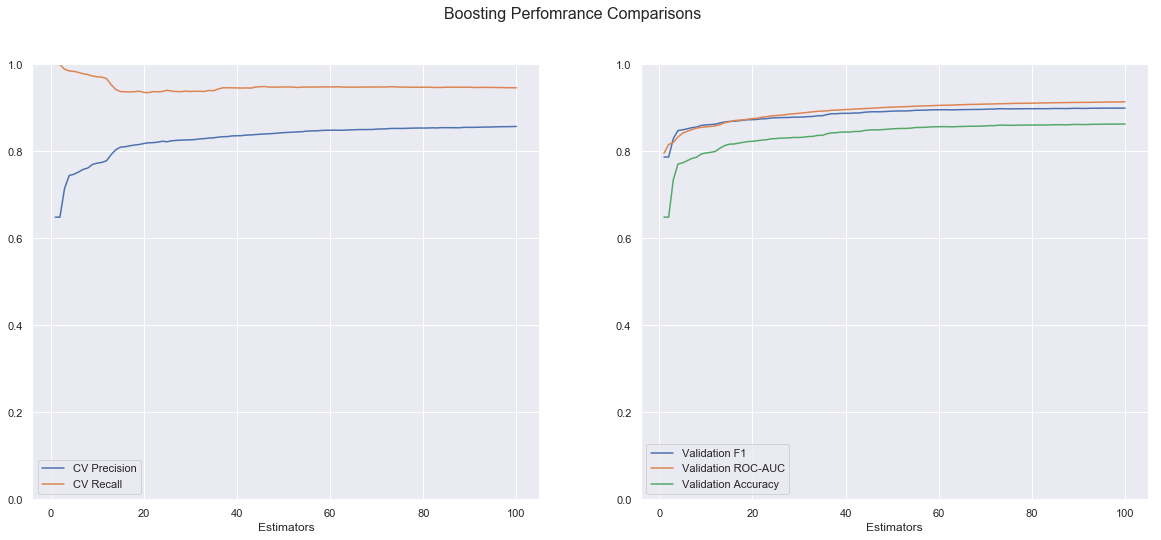

In [73]:
boost_df = get_cv_df(range(1,101), 'boosting')
plot_results(boost_df, 'Boosting', 'Estimators')

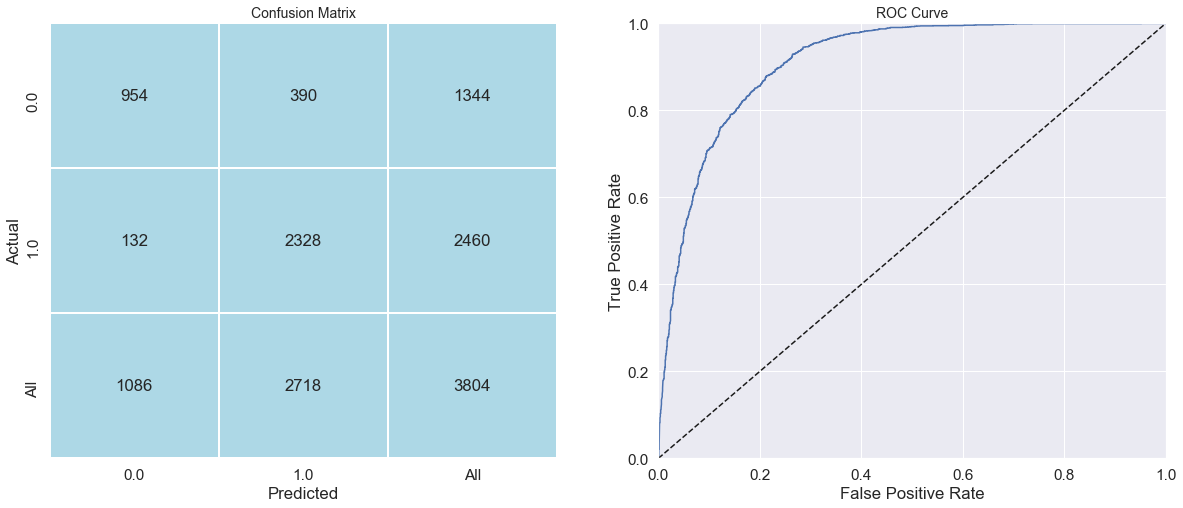

In [74]:
boost_clf = GradientBoostingClassifier(max_depth=2, n_estimators=boost_df['CV ROC-AUC'].argmax(), random_state=42)
scores = get_final(boost_clf)

In [75]:
model_scores['Boosting'] = [scores[i] for i in range(len(scores))]
model_scores

,Base Case,Decision Tree,Dense Neural Network,Boosting,Linear SVM,Kernel SVM,KNN
Accuracy,0.64837,0.843192,0.866982,0.862972,0.791340,0.800607,0.839709
F1,0.00000,0.846179,0.858589,0.857452,0.804669,0.777555,0.824584
Precision,0.00000,0.926968,0.950939,0.946109,0.895969,0.970320,0.956443
Recall,0.00000,0.884657,0.900522,0.899580,0.847822,0.863296,0.885612
ROC-AUC,0.50000,0.884000,0.913310,0.914000,0.834557,0.878045,0.900733


### Linear SVM

In [76]:
from sklearn.svm import LinearSVC, SVC

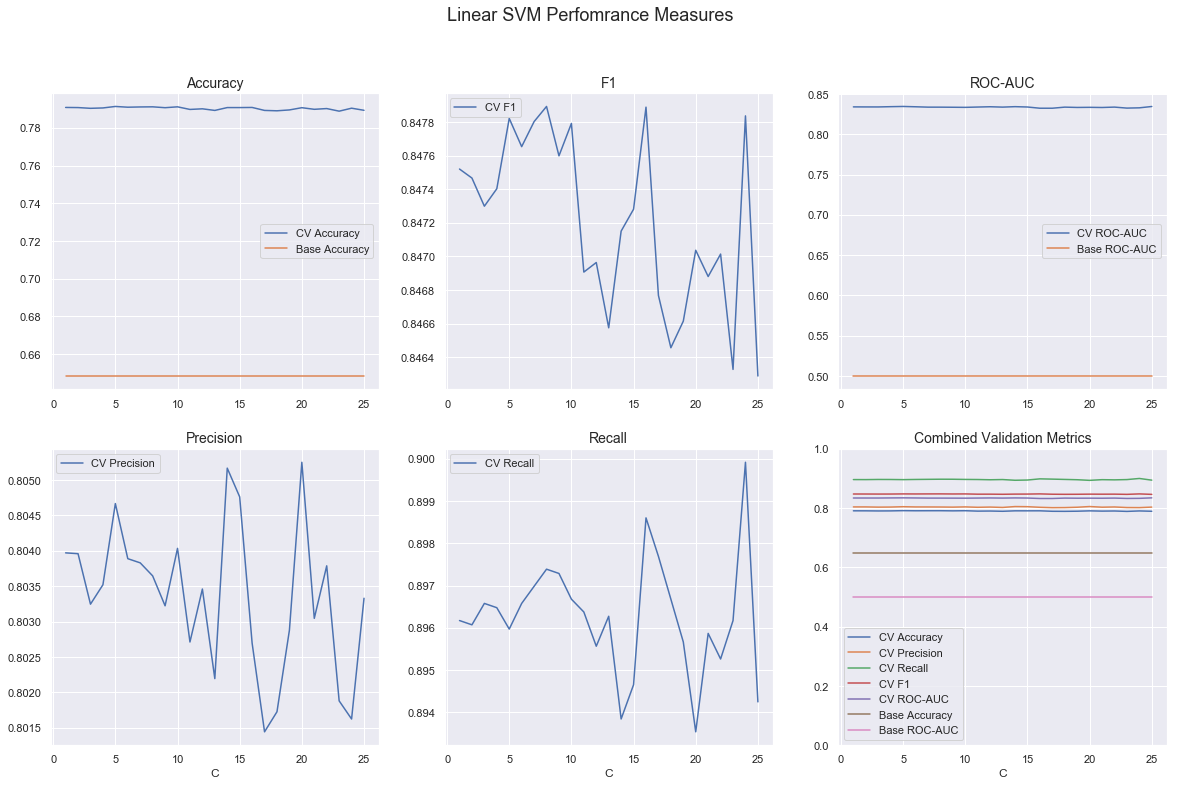

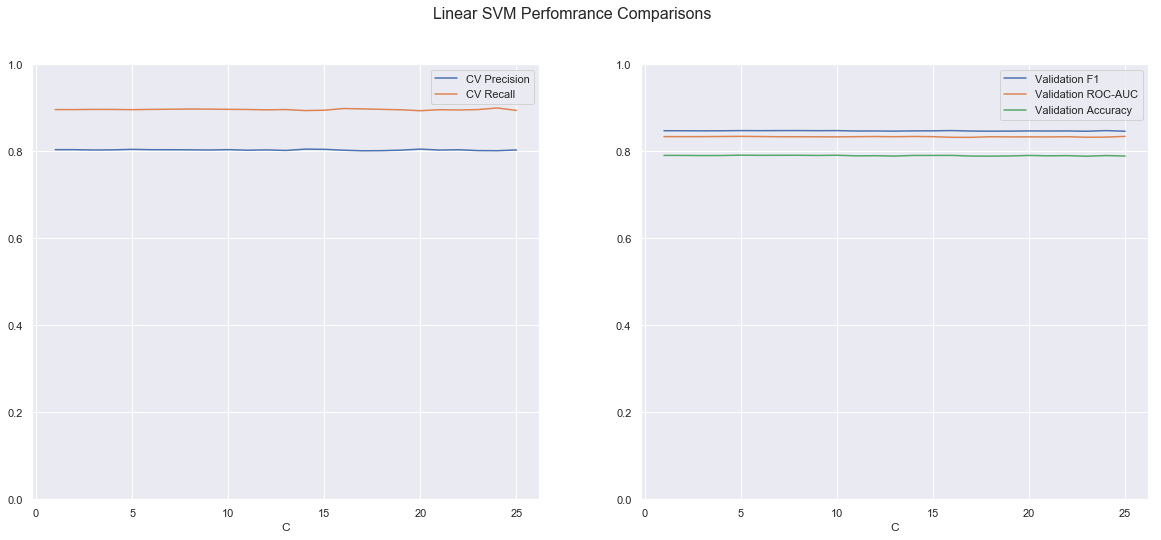

In [77]:
svm_df = get_cv_df(range(1,26), 'linear svm')
plot_results(svm_df, 'Linear SVM', 'C')

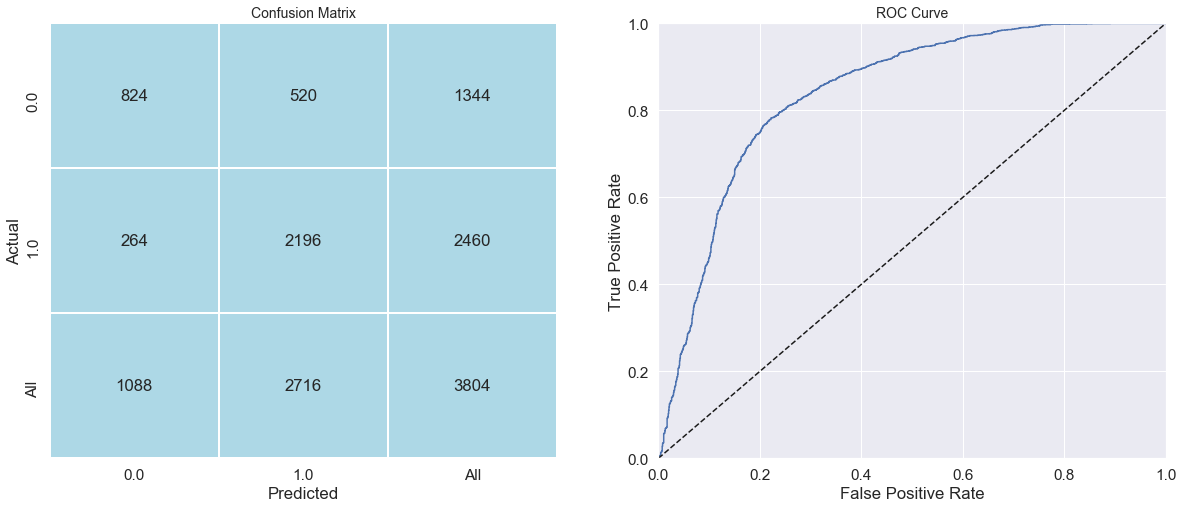

In [78]:
svm_clf = LinearSVC(loss='hinge', C=svm_df['CV ROC-AUC'].argmax(), random_state=42)
scores = get_final(svm_clf)

In [79]:
model_scores['Linear SVM'] = [scores[i] for i in range(len(scores))]
model_scores

,Base Case,Decision Tree,Dense Neural Network,Boosting,Linear SVM,Kernel SVM,KNN
Accuracy,0.64837,0.843192,0.866982,0.862972,0.791340,0.800607,0.839709
F1,0.00000,0.846179,0.858589,0.857452,0.804669,0.777555,0.824584
Precision,0.00000,0.926968,0.950939,0.946109,0.895969,0.970320,0.956443
Recall,0.00000,0.884657,0.900522,0.899580,0.847822,0.863296,0.885612
ROC-AUC,0.50000,0.884000,0.913310,0.914000,0.834557,0.878045,0.900733


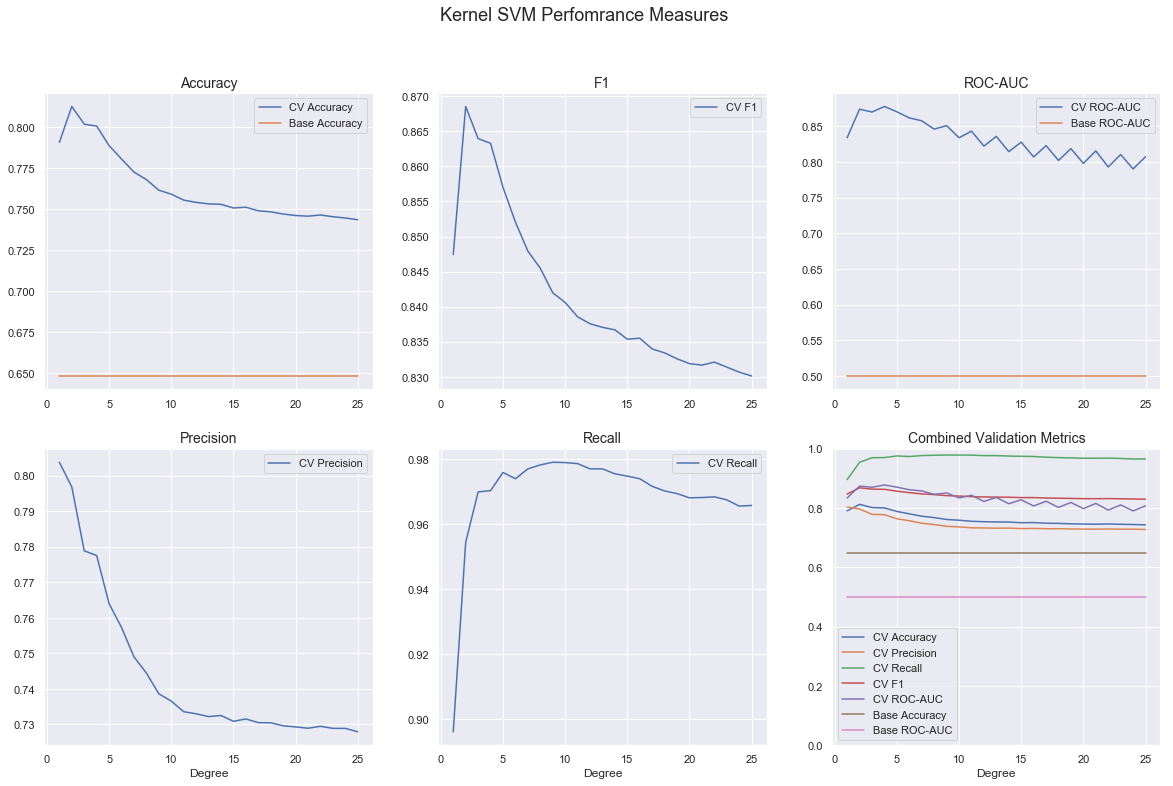

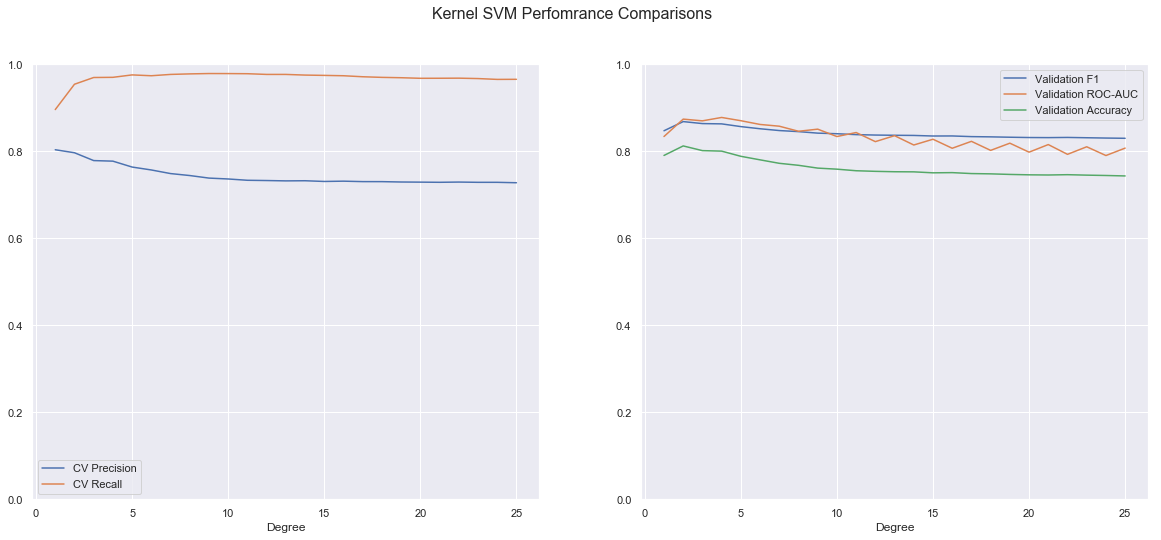

In [39]:
svm_df = get_cv_df(range(1,26), 'kernel svm')
plot_results(svm_df, 'Kernel SVM', 'Degree')

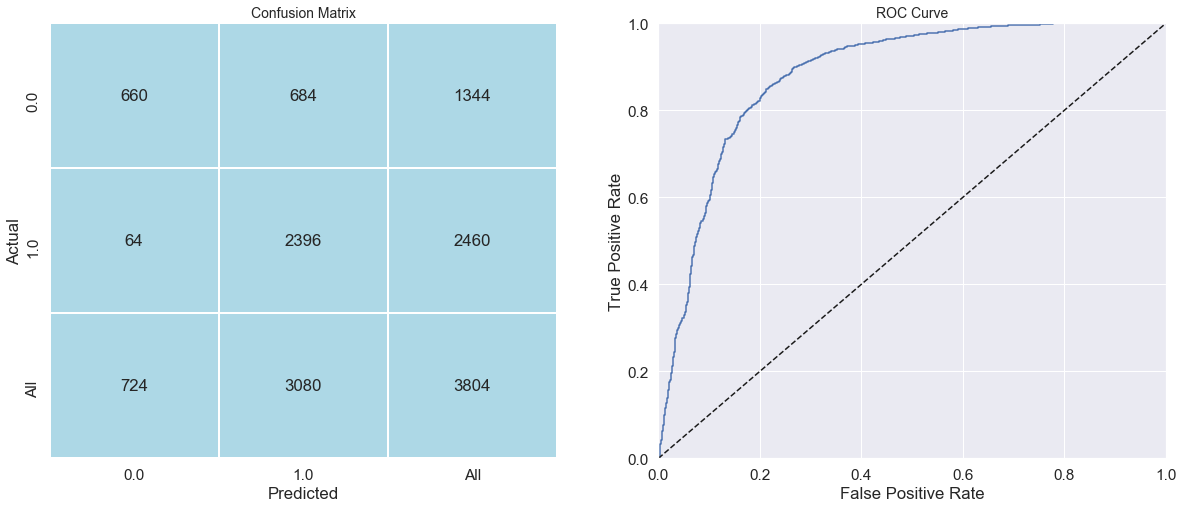

In [48]:
svm_clf = SVC(kernel='poly', degree=svm_df['CV ROC-AUC'].argmax(), random_state=42)
scores = get_final(svm_clf)

In [49]:
model_scores['Kernel SVM'] = [scores[i] for i in range(len(scores))]
model_scores

,Base Case,Decision Tree,Dense Neural Network,Boosting,Linear SVM,Kernel SVM
Accuracy,0.64837,0.843192,0.866982,0.862972,0.791340,0.800607
F1,0.00000,0.846179,0.858589,0.857452,0.804669,0.777555
Precision,0.00000,0.926968,0.950939,0.946109,0.895969,0.970320
Recall,0.00000,0.884657,0.900522,0.899580,0.847822,0.863296
ROC-AUC,0.50000,0.884000,0.913310,0.914000,0.834557,0.878045


### K-Nearest Neighbors

In [64]:
from sklearn.neighbors import KNeighborsClassifier

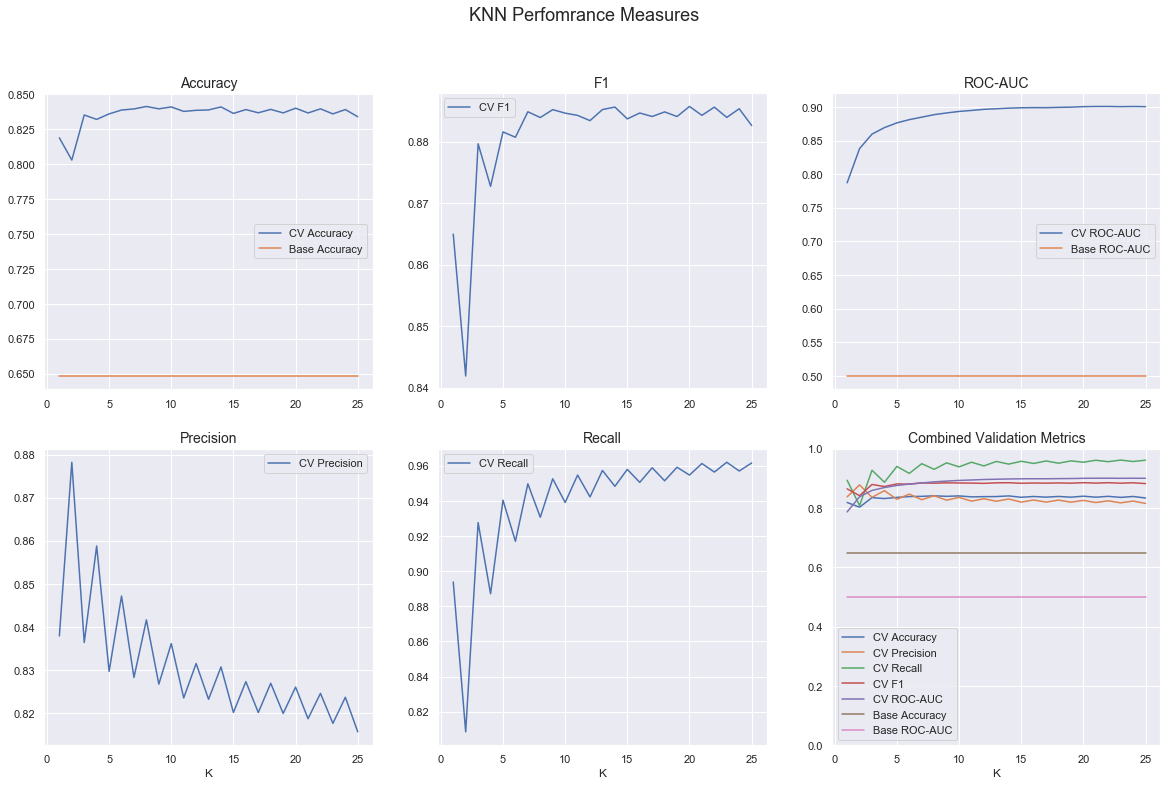

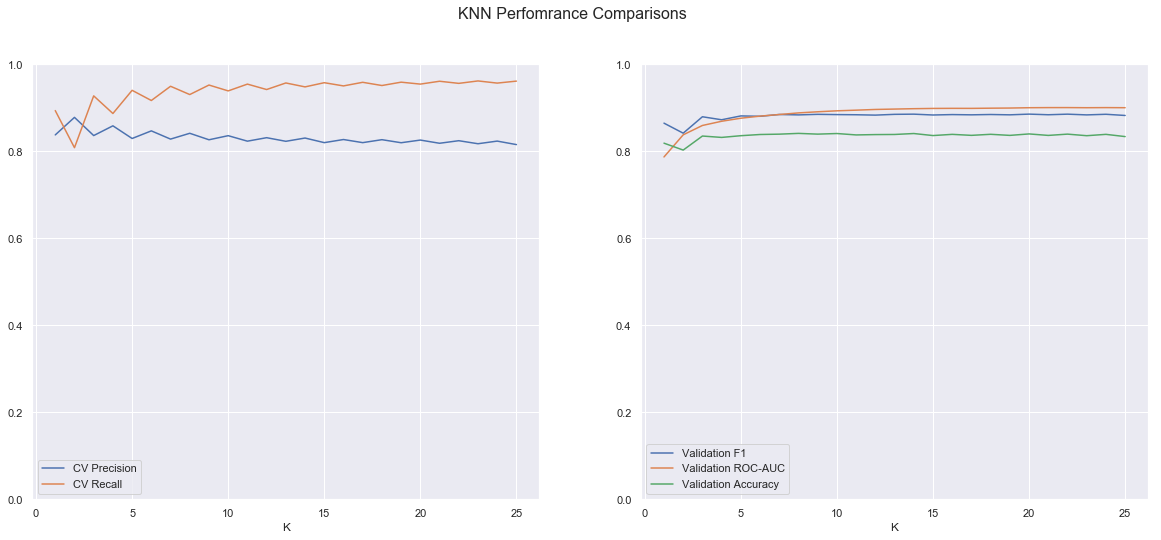

In [65]:
knn_df = get_cv_df(range(1,26), 'knn')
plot_results(knn_df, 'KNN', 'K')

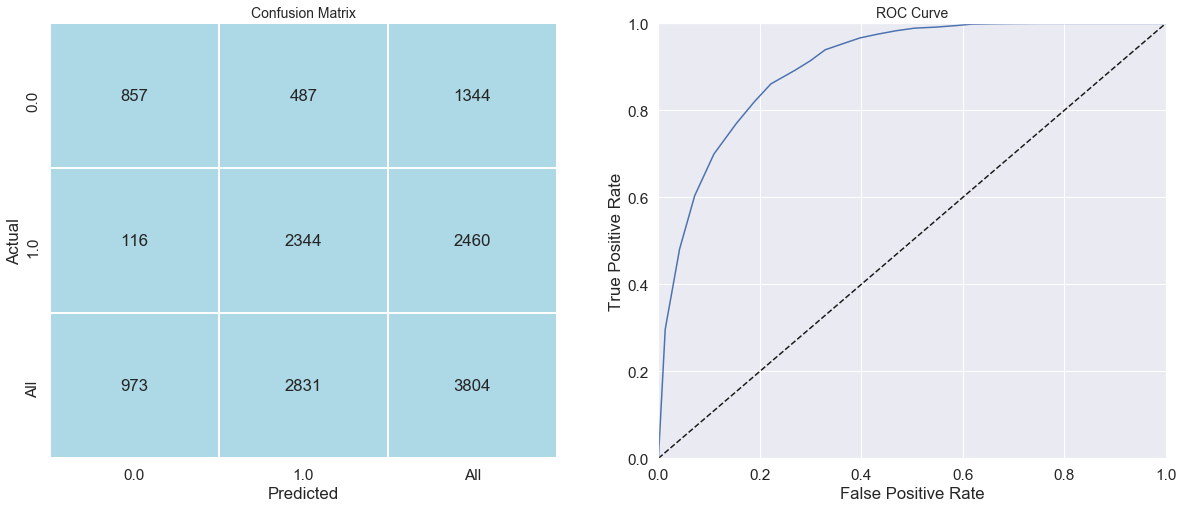

In [66]:
knn_clf = KNeighborsClassifier(n_neighbors=knn_df['CV ROC-AUC'].argmax())
scores = get_final(knn_clf)

In [67]:
model_scores['KNN'] = [scores[i] for i in range(len(scores))]
model_scores

,Base Case,Decision Tree,Dense Neural Network,Boosting,Linear SVM,Kernel SVM,KNN
Accuracy,0.64837,0.843192,0.866982,0.862972,0.791340,0.800607,0.839709
F1,0.00000,0.846179,0.858589,0.857452,0.804669,0.777555,0.824584
Precision,0.00000,0.926968,0.950939,0.946109,0.895969,0.970320,0.956443
Recall,0.00000,0.884657,0.900522,0.899580,0.847822,0.863296,0.885612
ROC-AUC,0.50000,0.884000,0.913310,0.914000,0.834557,0.878045,0.900733
